# NOTEBOOK_E0022_P06_Normalisation-assessment.ipynb

Completed by Rebecca Poulos.

Checked on 01/04/2020.

In [2]:
source_folder = '/Users/rpoulos/Documents/E0022_Project/E0022_github_source_folder/'

### Import libraries

In [3]:
import pandas as pd
import numpy as np
from numpy import array
import scipy.stats
import random
from random import shuffle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib import gridspec
from matplotlib import mlab
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as PathEffects
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.linear_model import Lasso as lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import nan_euclidean_distances
from Bio import SeqIO
from matplotlib.patches import Patch
from datetime import datetime
import datetime as dt
from sklearn.manifold import MDS
from sklearn import linear_model
import itertools

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='white', font_scale=1)

In [5]:
outline_props = dict(color='black',linewidth=0.25)

### Import sample mapping

In [4]:
df_sample_map = pd.read_csv('Generate_sample_mapping/E0022_P06_sample_map.txt', sep='\t').set_index('Automatic_MS_filename')
df_sample_map = df_sample_map.drop(['190119_6830_004nq_00865_m06_s_1', # Checked - failed OSW
                                   '190124_3473_004qw_008if_m06_s_1', # Checked - failed OSW
                                   '190522_5510_0088h_00be9_m04_s_1', # Checked - failed OSW
                                   '190701_2157_005ac_00ec5_m02_s_1', # Checked - failed OSW
                                   '190713_8922_005qu_00evu_m04_s_1', # Checked - failed OSW
                                   '191206_hek-qcs_00j8w_00ntp_m05_s_1']) # Checked - failed OSW
df_sample_map.loc['190618_hek-qcs_008sv_00c68_m02_s_1','Code'] = 'HEK H002' # Checked - file rename error by Proteomics, correcting it here
df_sample_map.loc['190618_hek-qcs_008sv_00c68_m02_s_1','Daisy_chain'] = 'No' # Checked - file rename error by Proteomics, correcting it here
df_sample_map.loc['190618_hek-qcs_008sv_00c68_m02_s_1','Replicate'] = '1' # Checked - file rename error by Proteomics, correcting it here
df_sample_map.loc['190618_hek-qcs_008sv_00c68_m02_s_1','Cell_line'] = 'Control_HEK293T_std_H002' # Checked - file rename error by Proteomics, correcting it here
df_sample_map.loc['190618_hek-qcs_008sv_00c68_m02_s_1',df_sample_map.columns.tolist()[7:]] = 'Control_HEK293T'# Checked - file rename error by Proteomics, correcting it here

### Set colours

In [5]:
instrument_colours={
    'M01':'#66c2a5', 
    'M02':'#fc8d62', 
    'M03':'#8da0cb', 
    'M04':'#e78ac3', 
    'M05':'#a6d854', 
    'M06':'#ffd92f'
}

batch_colours={
    'P01':'#7fc97f', 
    'P02':'#beaed4', 
    'P03':'#fdc086', 
    'P04':'#386cb0', 
    'P05':'#f0027f', 
    'P06':'#bf5b17'
}

hek_colours = {
    'Control_HEK293T_lys': '#d8b365',
    'Control_HEK293T_std_H002': '#5ab4ac',
    'Control_HEK293T_std_H003': '#addad6'
}

instrument_patch = []
for instrument in instrument_colours:
    instrument_patch.append(Patch(facecolor=instrument_colours[instrument], edgecolor='black', label=''))

In [6]:
colour_list = pd.read_csv('colour_list.txt',header=None)[0].tolist()

num = 0
cancer_colours = {}
for cancer_type in df_sample_map['Cancer_type'].unique().tolist():
    cancer_colours[cancer_type]= colour_list[num]
    num += 1

num = 0
tissue_colours = {}
for tissue_type in df_sample_map['Tissue_type'].unique().tolist():
    tissue_colours[tissue_type] = colour_list[num]
    num += 1

In [7]:
instruments = sorted(df_sample_map['Instrument'].unique().tolist())
batches = sorted(df_sample_map['Batch'].unique().tolist())
cell_lines = sorted(df_sample_map['Cell_line'].astype(str).unique().tolist())
cancer_types = sorted(df_sample_map['Cancer_type'].unique().tolist())
tissue_types = sorted(df_sample_map['Tissue_type'].unique().tolist())

In [8]:
df_colours = df_sample_map[['Instrument','Batch','Cancer_type','Tissue_type']]
df_colours.loc['Instrument'] = df_colours.loc[:,'Instrument'].map(instrument_colours)
df_colours.loc[:,'Batch'] = df_colours.loc[:,'Batch'].map(batch_colours)
df_colours.loc[:,'Cancer_type'] = df_colours.loc[:,'Cancer_type'].map(cancer_colours)
df_colours.loc[:,'Tissue_type'] = df_colours.loc[:,'Tissue_type'].map(tissue_colours)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


### Import master dataset

In [9]:
df_master = pd.read_csv(source_folder+'E0022_P06_dataset_d7af39b2-4c0e-430f-89aa-4549b8221d01.csv.gz', sep='\t')
df_master['Identifier'] = df_master['Protein'] +'='+ df_master['Peptide'] +'='+ df_master['ModifiedPeptide']
df_master = df_master.drop(['Protein','Peptide','ModifiedPeptide'], axis=1).set_index('Identifier').transpose()
rename_dict = {}
for x in df_master.columns.tolist():
    if 'RMIS_tmp' in x:
        rename_dict[x] = x.replace('_RMIS_tmp','').split('|')[2]
df_master = df_master.rename(columns=rename_dict)

In [10]:
print('Number of samples analysed:',df_master.shape[0])
print('Missing value percentage:',format((df_master.isna().sum().sum()/df_master.size)*100,'.2f'),'%')

Number of samples analysed: 7159
Missing value percentage: 57.12 %


In [11]:
# pd.DataFrame(index=list(set([x.split('=')[0] for x in df_master.columns.tolist()]))).to_csv(source_folder+'master_protein_list.txt')

### Perform initial data QC

In [12]:
print('Average peptides per sample (master):', round(df_master.count(axis=1).mean()))
proteins_df = pd.DataFrame()
curr_df = df_master.transpose().reset_index()
curr_df[['Protein','Peptide','ModPeptide']] = curr_df['Identifier'].str.split('=', expand=True)
for sample in df_master.index.tolist():
    proteins_df.loc[sample,'Proteins_identified'] = (len(curr_df[['Protein',sample]].dropna()['Protein'].unique().tolist()))
print('Average proteins per sample (master):', round(proteins_df['Proteins_identified'].mean()))

Average peptides per sample (master): 15802
Average proteins per sample (master): 3142


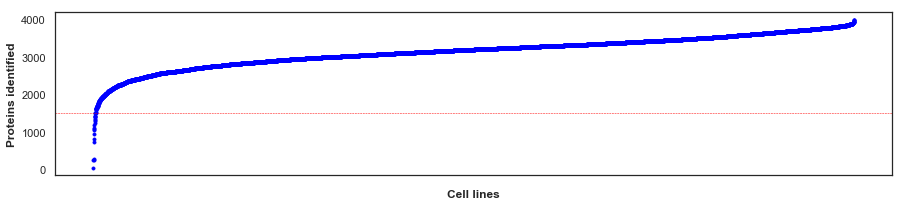

Bad files to be removed: 20


In [13]:
threshold = 1500
fig = plt.figure(figsize=[15,3])
curr_df = proteins_df.sort_values('Proteins_identified')
plot_df = curr_df.reset_index().reset_index().rename(columns={'level_0':'Sample'})
plot = sns.scatterplot(data=plot_df, x='Sample', y='Proteins_identified', s=10, color='blue', edgecolor='blue')
plot.axhline(y=threshold, color='red', linestyle='--', linewidth=0.5)
plot.set_xticklabels([])
plot.set_xlabel('Cell lines', weight='bold')
plot.set_ylabel('Proteins identified', weight='bold')
plt.show()
bad_files = proteins_df[lambda x: x.Proteins_identified < threshold].index.tolist()
print('Bad files to be removed:', len(bad_files))

### Finalise datasets

##### Remove bad files

In [14]:
print('Original dataset contained:',df_master.shape[0])
df_raw = df_master.copy()
df_raw = df_raw[lambda x: ~x.index.isin(bad_files)]
print('Final dataset contained:',df_raw.shape[0])
# df_raw.to_csv(source_folder+'E0022_P06_raw_peptide_matrix.csv.gz', compression='gzip')
df_sample_map = df_sample_map[lambda x: x.index.isin(df_raw.index.tolist())]
dict_sample_map = df_sample_map.to_dict()

Original dataset contained: 7159
Final dataset contained: 7139


##### Log-transformed peptide data

In [15]:
df_log = df_raw.apply(np.log2)
# df_log.to_csv(source_folder+'E0022_P06_log_transformed.csv.gz', compression='gzip')

##### Protein data

In [16]:
protein_df = df_log.transpose().reset_index()
protein_df[['Protein','Peptide','ModPeptide']] = protein_df['Identifier'].str.split('=',expand=True)
protein_df = protein_df.drop(['Identifier','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
# protein_df.to_csv(source_folder+'ForDiffacto_E0022_P06_log_transformed.txt',index=False)

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_log_transformed.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_log_transformed.tsv

##### Get final peptide and protein stats

In [17]:
print('Average peptides per sample:', round(df_raw.count(axis=1).mean()))
proteins_df = pd.DataFrame()
curr_df = df_raw.transpose().reset_index()
curr_df[['Protein','Peptide','ModPeptide']] = curr_df['Identifier'].str.split('=', expand=True)
for sample in df_raw.index.tolist():
    proteins_df.loc[sample,'Proteins_identified'] = (len(curr_df[['Protein',sample]].dropna()['Protein'].unique().tolist()))
print('Average proteins per sample:', round(proteins_df['Proteins_identified'].mean()))

Average peptides per sample: 15838
Average proteins per sample: 3148


In [18]:
frequent_peptides = df_raw.apply(lambda x: (x.count()/x.shape[0])*100).to_frame('Freq')[lambda x: x.Freq > 80].index.tolist()
print('Number of peptides observed in > 80% of runs:',len(frequent_peptides))

Number of peptides observed in > 80% of runs: 5831


In [19]:
peptide_dict = {}
for x in df_raw.columns.tolist():
    peptide_dict[x]=x.split('=')[0]
curr_df = df_raw.rename(columns=peptide_dict).transpose().reset_index()
curr_df = curr_df.groupby('Identifier').count().replace(0,np.nan)
curr_df[curr_df > 0] = 1
protein_count = ((curr_df.sum(axis=1)/curr_df.shape[1])*100).to_frame('Freq')
frequent_proteins = protein_count[lambda x: x.Freq > 99].index.tolist()
print('Number of frequently-observed proteins (>99% of samples):', len(frequent_proteins))
frequent_proteins_full_peptide = [x for x in df_raw.columns.tolist() if x.split('=')[0] in frequent_proteins]
print('Number of peptides from frequently-observed proteins:',len(frequent_proteins_full_peptide))

Number of frequently-observed proteins (>99% of samples): 690
Number of peptides from frequently-observed proteins: 13715


### Generate random cell line order

In [20]:
# cell_line_rndm = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
# random.shuffle(cell_line_rndm)
# cell_line_rndm = cell_line_rndm[0:100]
# pd.DataFrame(index=cell_line_rndm).reset_index().to_csv(source_folder+'cell_line_rndm_list.txt', index=False, header=False)

In [21]:
cell_line_rndm = pd.read_csv(source_folder+'cell_line_rndm_list.txt',header=None)[0].tolist()
print('Selected random cell lines:',len(cell_line_rndm))

Selected random cell lines: 100


### Examine correlation with RNA

##### Import RNA-seq data

In [22]:
df_rna = pd.read_csv(source_folder+'rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
# rna_gene_list = pd.DataFrame(index=df_rna.index.tolist()).reset_index().to_csv(source_folder+'rna_gene_list.txt', index=False)
df_rna = df_rna.rename(columns=df_sample_map[['SIDM','Cell_line']].set_index('SIDM').to_dict()['Cell_line'])
df_rna = df_rna[[x for x in df_rna.columns.tolist() if 'SIDM' not in x]]
gene_to_protein_mapping = pd.read_csv(source_folder+'master_protein_to_gene_mapping.txt', sep='\t').set_index('To').to_dict()['From']
df_rna.index = df_rna.index.map(gene_to_protein_mapping)
df_rna = df_rna[lambda x: ~x.index.isna()].transpose()
df_rna = df_rna[[x for x in df_rna.columns.tolist() if df_rna.columns.tolist().count(x) == 1]]
# df_rna.to_csv(source_folder+'rnaseq_data_commonCellLines_commonProteins.txt', sep='\t')

##### Define functions

In [23]:
def get_peptide_correlation_with_rna(dtaframe,title):
    corr_df = pd.DataFrame()
    dtaframe_ave = dtaframe.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()
    proteins = [x for x in df_rna.columns.tolist() if x in list(set([x.split('=')[0] for x in dtaframe_ave.columns.tolist()]))]
    for protein in proteins:
        for peptide in [x for x in dtaframe_ave.columns.tolist() if protein in x]:
            curr_df = dtaframe_ave[[peptide]].join(df_rna[[protein]]).dropna()
            if len(curr_df) > 1:
                corr_df.loc[peptide,'Correlation'] = scipy.stats.pearsonr(curr_df[peptide], curr_df[protein])[0]
                corr_df.loc[peptide,'Protein'] = protein
    corr_df_prot = corr_df.groupby('Protein').mean()
    plot = sns.distplot(corr_df['Correlation'], color='blue', hist=False, label='All peptides: '+str(format(corr_df['Correlation'].median(),'.2f')))
    plot = sns.distplot(corr_df_prot['Correlation'], color='orange', hist=False, label='Per protein: '+str(format(corr_df_prot['Correlation'].median(),'.2f')))
    plot.axvline(x=corr_df['Correlation'].median(), linestyle='--', linewidth=1, color='blue')
    plot.axvline(x=corr_df_prot['Correlation'].median(), linestyle='--', linewidth=1, color='orange')
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title('Correlation of peptides with RNA\n'+title, fontsize=14, weight='bold')
    plt.legend(fontsize=14, frameon=False)
    plt.show()

In [24]:
def get_rna_protein_correlation(dtaframe):
    rna_corr = pd.DataFrame()
    for protein in dtaframe.columns.tolist():
        if protein in df_rna.columns.tolist():
            curr_df = dtaframe[[protein]].rename(columns={protein:'Protein'}).join(df_rna[[protein]]).rename(columns={protein:'RNA'}).dropna()
            if len(curr_df) > 1:
                pearson_corr = scipy.stats.pearsonr(curr_df['Protein'], curr_df['RNA'])[0]
                rna_corr.loc[protein,'Correlation'] = pearson_corr
    return rna_corr

def generate_correlation_plot(dtaframes, labels, title):
    num = 0
    for dtaframe in dtaframes:
        plot = sns.distplot(dtaframe['Correlation'].dropna(), color=colour_list[num], hist=False, label=labels[num]+' - '+str(format(dtaframe['Correlation'].median(),'.2f')))
        plot.axvline(x=dtaframe['Correlation'].median(), color=colour_list[num], linewidth=1, linestyle='--')
        num += 1
    plot.set_xlabel('Correlation', weight='bold')
    plot.set_ylabel('Frequency', weight='bold')
    plot.set_title(title, fontsize=14, weight='bold')
    plt.show()

##### Get peptide-level correlation with RNA

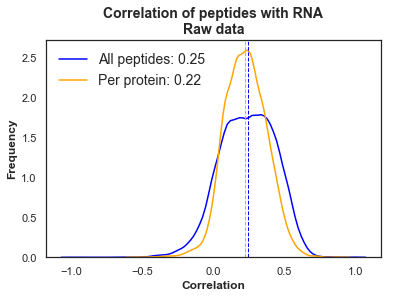

In [27]:
get_peptide_correlation_with_rna(df_raw,'Raw data')

##### Get protein-level correlation with RNA

In [40]:
df_protein_raw = pd.read_csv(source_folder+'FromDiffacto_E0022_P06_log_transformed.tsv', sep='\t')
df_protein_raw = df_protein_raw.drop(['N.Pept','Q.Pept','S/N','P(PECA)'], axis=1).set_index('Protein').transpose()
df_protein_raw = df_protein_raw.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()

In [41]:
rna_corr_raw = get_rna_protein_correlation(df_protein_raw)

In [42]:
curr_df = df_protein_raw.loc[cell_line_rndm,frequent_proteins]
rna_corr_raw_minimal = get_rna_protein_correlation(curr_df)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


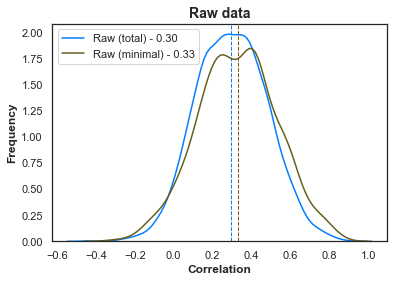

In [96]:
generate_correlation_plot([rna_corr_raw, rna_corr_raw_minimal], ['Raw (total)','Raw (minimal)'], 'Raw data')

### Assign negative controls

##### Define function

In [29]:
def generate_neg_control_plot(dtaframe, peptide_list, variable, colour_dict, rot_val):
    plot_df = dtaframe[peptide_list].join(df_sample_map[variable]).set_index(variable).unstack().to_frame('Intensity').reset_index().drop('level_0', axis=1).sort_values(variable)
    plot = sns.boxplot(x=variable, y='Intensity', hue=variable, data=plot_df, showfliers=False, palette=colour_dict, dodge=False)
    plot.set_xlabel('')
    xticklabels = []
    for p in plot.get_xticklabels():
        xticklabels.append(p.get_text()+'\n(n='+str(df_sample_map.groupby(variable).size().to_frame('num').loc[p.get_text(),'num'])+')')
    plot.set_xticklabels(xticklabels, rotation=rot_val)
    plot.legend_.remove()
    plot.set_title(variable, fontsize=14, weight='bold')
    return plot

##### Control peptides

In [30]:
possible_control_peptides = df_raw.apply(lambda x: (x.count()/x.shape[0])*100).to_frame('Freq')[lambda x: x.Freq > 90].index.tolist()
curr_df = df_raw[possible_control_peptides].apply(lambda x: x.std()/x.mean()*100).to_frame('CV')
control_peptides = curr_df[lambda x: x.CV < 75].index.tolist()
print('Control peptides:',len(control_peptides))
# pd.DataFrame(index=list(set([x.split('=')[0] for x in control_peptides]))).reset_index().to_csv(source_folder+'negative_control_protein_list.txt', sep='\t', index=False)

Control peptides: 1626


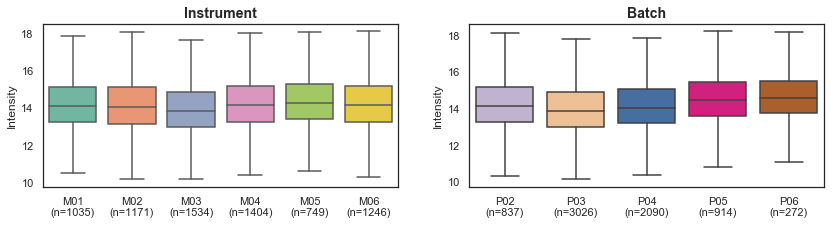

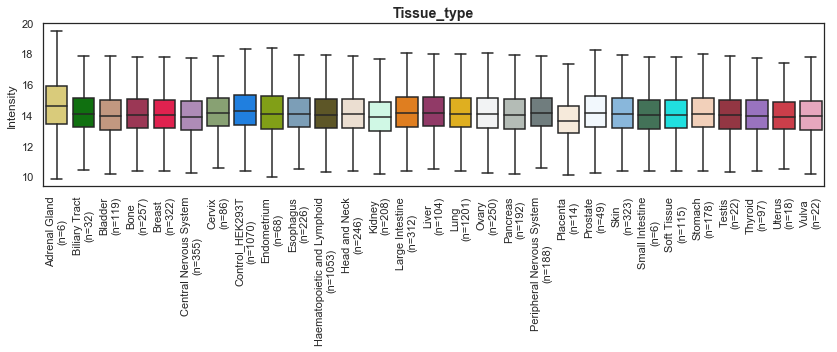

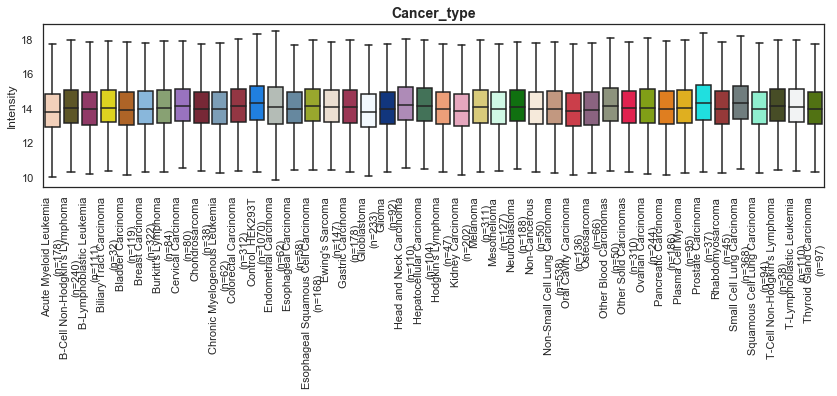

In [31]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_log, control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_log, control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

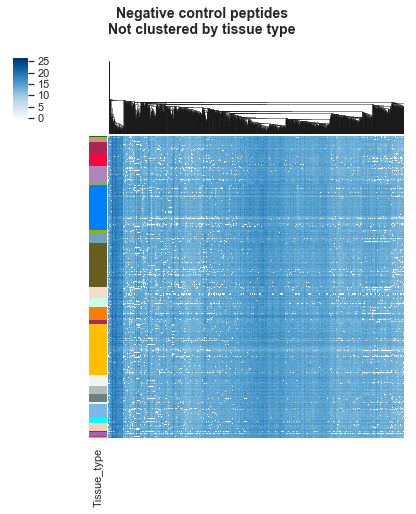

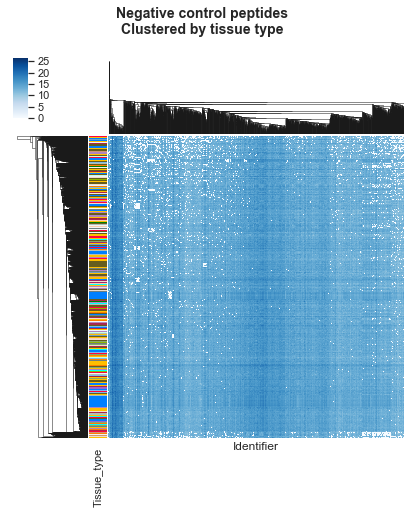

In [165]:
plot = sns.clustermap(df_log[control_peptides].fillna(0).join(df_sample_map['Tissue_type']).sort_values('Tissue_type').drop('Tissue_type',axis=1), figsize=[7,7], row_cluster=False, col_cluster=True, xticklabels=False, yticklabels=False, row_colors=df_colours[['Tissue_type']], cmap='Blues')
plot.fig.suptitle('Negative control peptides\nNot clustered by tissue type', weight='bold', fontsize=14)
plt.show()

plot = sns.clustermap(df_log[control_peptides].fillna(0), figsize=[7,7], row_cluster=True, col_cluster=True, xticklabels=False, yticklabels=False, row_colors=df_colours[['Tissue_type']], cmap='Blues')
plot.fig.suptitle('Negative control peptides\nClustered by tissue type', weight='bold', fontsize=14)
plt.show()

##### iRT peptides

In [33]:
biognosys_peptides = [x for x in df_raw.columns.tolist() if 'Biognosys' in x]
irt_peptides = [x for x in df_raw.columns.tolist() if 'RMIS' in x or 'Biognosys' in x]
print('Number of Biognosys peptides:',len(biognosys_peptides))
print('Number of iRT peptides:',len(irt_peptides))

Number of Biognosys peptides: 11
Number of iRT peptides: 67


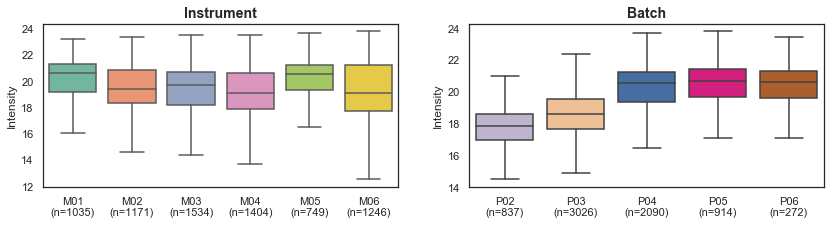

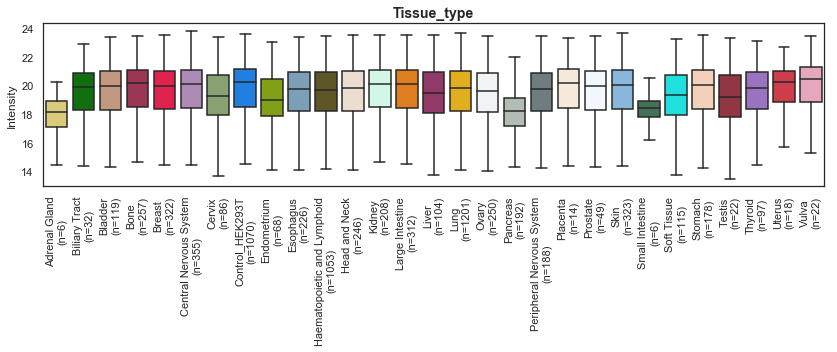

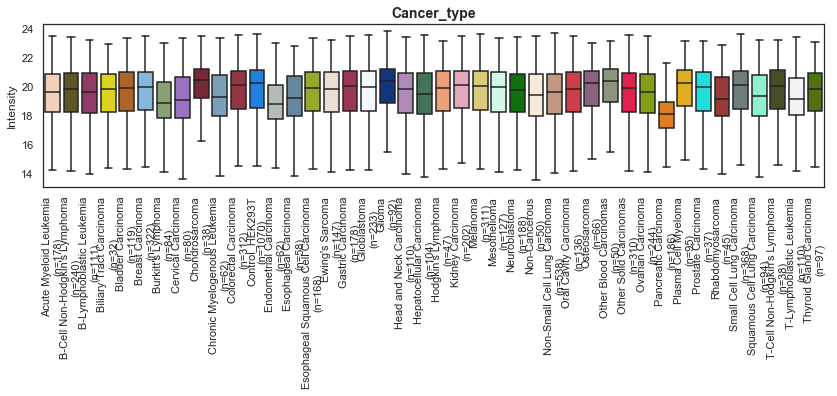

In [80]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_log, irt_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_log, irt_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, irt_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, irt_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

##### Almost control peptides

In [81]:
possible_control_peptides = df_raw.apply(lambda x: (x.count()/x.shape[0])*100).to_frame('Freq')[lambda x: (x.Freq <= 90) & (x.Freq > 80)].index.tolist()
curr_df = df_raw[possible_control_peptides].apply(lambda x: x.std()/x.mean()*100).to_frame('CV')
almost_control_peptides = curr_df[lambda x: x.CV < 75].index.tolist()
print('Almost control peptides:',len(almost_control_peptides))

Almost control peptides: 1132


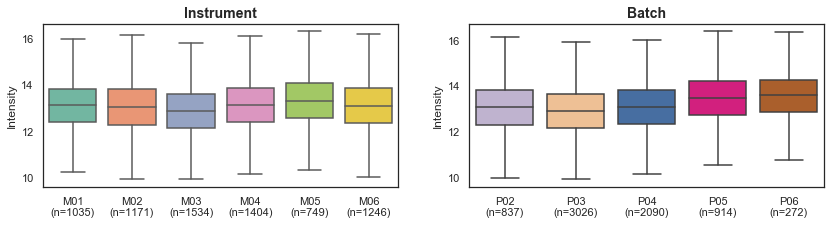

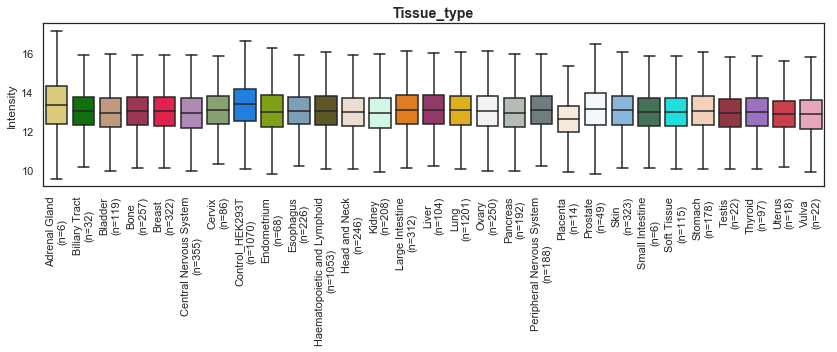

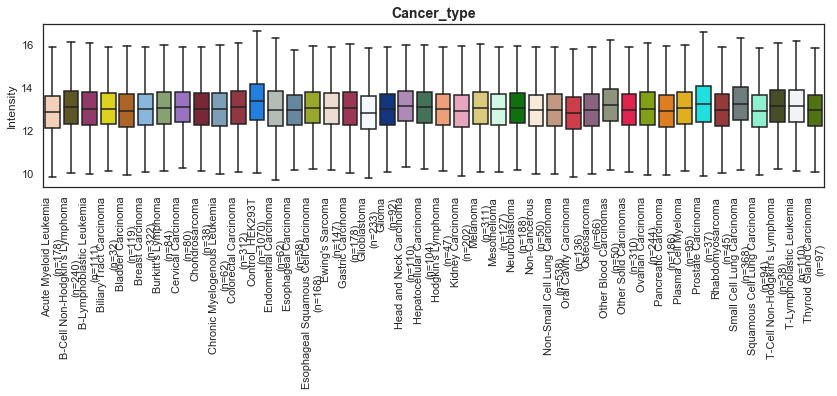

In [82]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_log, almost_control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_log, almost_control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, almost_control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_log, almost_control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

In [87]:
def make_hek_cleaning_plot(dtaframe):
    df_hek_std = dtaframe[almost_control_peptides].join(df_sample_map['Cell_line'])[lambda x: x.Cell_line == 'Control_HEK293T_std_H002'].drop('Cell_line',axis=1)
    curr_df = df_hek_std.unstack().to_frame('Intensity').reset_index().drop('level_0', axis=1).rename(columns={'level_1':'Sample'}).set_index('Sample').join(df_sample_map[['Date','Instrument']]).sort_values('Date').reset_index()
    fig = plt.figure(figsize=[15,10])
    for instrument in instruments:
        ax = fig.add_subplot(2,3,int(instrument.split('0')[1]))
        plot_df = curr_df[lambda x: x.Instrument == instrument]
        plot = sns.boxplot(x='index', y='Intensity', data=plot_df, showfliers=False, color=instrument_colours[instrument], whiskerprops=outline_props, capprops=outline_props, medianprops=outline_props, boxprops=dict(linewidth=1))
        plot.set_xticklabels([])
        plot.set_title(instrument, weight='bold')
        plot.set_xlabel('')
    plt.subplots_adjust(wspace=0.4)
    plt.show()

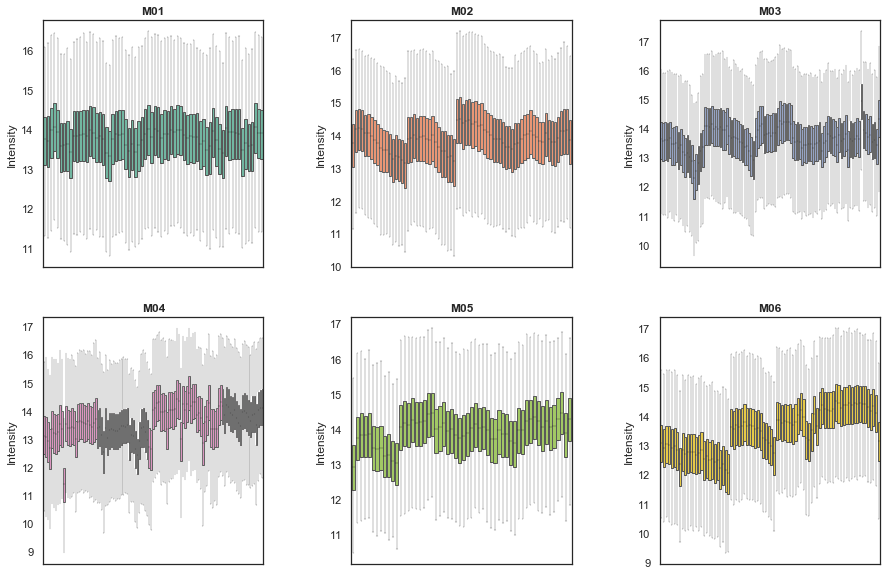

In [88]:
make_hek_cleaning_plot(df_log)

### Write data for RUV-III-C

##### Peptide matrix for normalisation

In [38]:
# df_log.to_csv(source_folder+'ForRUV_P06_dataset_adjustedMatrix.txt.gz', index_label=False, compression='gzip')

##### Replicate matrix for use in normalisation

In [39]:
curr_df = df_log.join(df_sample_map['Cell_line']).reset_index()[['index','Cell_line']].rename(columns={'Cell_line':'RUV_Replicate'})
# curr_df.to_csv(source_folder+'ForRUV_P06_dataset_replicates.txt', index=False)

##### Control and non-control peptides for normalisation

In [40]:
# pd.DataFrame(index=control_peptides).reset_index().transpose().to_csv(source_folder+'ForRUV_P06_dataset_negativeControls.txt', header=False, index=False)
non_control_peptides = [x for x in df_raw.columns.tolist()]
# pd.DataFrame(index=non_control_peptides).reset_index().transpose().to_csv(source_folder+'ForRUV_P06_dataset_nonControls.txt', header=False, index=False)

### Assess normalisation

Notes: 
* All runs of RUV except k = 4 were completed with one H002 sample incorectly marked as NCI-H526.
* Correlation with RNA does not apply S/N threshold filter

##### Define functions

In [25]:
def get_normalisation_stats(kval):
    dtaframe = pd.read_csv(source_folder+'FromRUV_E0022_P06_dataset_normalised_k'+kval+'.csv')
    # Generate Diffacto input
    protein_df = dtaframe[[x for x in frequent_proteins_full_peptide if x in dtaframe.columns.tolist()]].join(df_sample_map['Cell_line'])[lambda x: x.Cell_line.isin(cell_line_rndm)].drop('Cell_line', axis=1)
    peptides_to_remove = protein_df.count().to_frame('Count')[lambda x: x['Count'] < 5].index.tolist()
    protein_df = protein_df[[x for x in protein_df.columns.tolist() if x not in peptides_to_remove]].transpose().reset_index()
    protein_df[['Protein','Peptide','ModPeptide']] = protein_df['index'].str.split('=',expand=True)
    protein_df = protein_df.drop(['index','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
#     protein_df.to_csv(source_folder+'ForDiffacto_E0022_P06_minimal_dataset_k'+kval+'.txt',index=False)
    # Calculate CV
    df_cv = dtaframe.apply(lambda x: 2**x)[[x for x in frequent_peptides if x in dtaframe.columns.tolist()]].join(df_sample_map['Cell_line']).groupby('Cell_line').apply(lambda x: (x.std()/x.mean())*100)
    df_cv = df_cv.to_frame('CV').reset_index().drop('level_1', axis=1)
    df_cv = df_cv.groupby('Cell_line').median()
    # Calculate minimum pearson correlation
    cell_lines_noHEK = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
    corr_df = pd.DataFrame()
    for cell_line in cell_lines_noHEK:
        corr_df.loc[cell_line,'Corr'] = dtaframe.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr().min().min()
    corr_df = corr_df.join(df_cv)
    return corr_df

In [26]:
def generate_qc_scatter_plot(dtaframe):
    cv_thresh = 42
    corr_thresh = 0.9675
    plot = sns.scatterplot(x='CV', y='Corr', data=dtaframe, color='blue')
    plot.set_xlabel('Coefficient of variation (CV, %)', weight='bold')
    plot.set_ylabel('Pearson correlation', weight='bold')
    plot.axvline(x=cv_thresh, color='red', linestyle='--', linewidth=0.5)
    plot.axhline(y=corr_thresh, color='red', linestyle='--', linewidth=0.5)    
    plot.set_xlim(0,75)
    plot.set_ylim(0.85, 1)
    return plot

In [35]:
def calculate_correlation_with_rna(kval, dtaframe):
    df_prot = pd.read_csv(source_folder+'FromDiffacto_E0022_P06_minimal_dataset_k'+kval+'.tsv', sep='\t')
    df_prot = df_prot.drop(['N.Pept','Q.Pept','S/N','P(PECA)'], axis=1).set_index('Protein').transpose()
    df_ave = df_prot.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()
    rna_corr = pd.DataFrame()
    for protein in df_ave.columns.tolist():
        if protein in df_rna.columns.tolist():
            curr_df = df_ave[[protein]].rename(columns={protein:'Protein'}).join(df_rna[[protein]]).rename(columns={protein:'RNA'}).dropna()
            if len(curr_df) > 1:
                rna_corr.loc[protein,'Correlation'] = scipy.stats.pearsonr(curr_df['Protein'], curr_df['RNA'])[0]
    return rna_corr['Correlation'].mean(), dtaframe['Corr'].mean(), dtaframe['CV'].mean()

In [28]:
def make_comparison_plots(xval, yval, num, dtaframe, showval):
    label_dict = {'RNA_corr':'Correlation with RNA', 'Rep_corr':'Correlation across replicates', 'Rep_CV':'Coefficient of variation (CV), %'}
    ax = fig.add_subplot(1,3,num)
    plot = sns.scatterplot(x=xval, y=yval, data=dtaframe, color='blue')
    plot.set_xlabel(label_dict[xval], weight='bold')
    plot.set_ylabel(label_dict[yval], weight='bold')
    for val in dtaframe.index.tolist():
        plot.text(dtaframe.loc[val,xval], dtaframe.loc[val,yval], ' '+str(val), color='blue', weight='bold')
    if xval == 'Rep_CV':
        plt.xlim(reversed(plt.xlim()))
    if yval == 'Rep_CV':
        plt.ylim(reversed(plt.ylim()))
    if showval == 'Show_raw':
        raw_dict_full = {'RNA_corr':rna_corr_raw['Correlation'].mean(), 'Rep_corr':corr_df['Corr'].mean(), 'Rep_CV':corr_df['CV'].mean()}
        raw_dict_minimal = {'RNA_corr':rna_corr_raw_minimal['Correlation'].mean(), 'Rep_corr':corr_df['Corr'].mean(), 'Rep_CV':corr_df['CV'].mean()}
        if xval=='RNA_corr' or yval=='RNA_corr':
            plot.scatter(x=raw_dict_minimal[xval], y=raw_dict_minimal[yval], color='red')
            plot.text(raw_dict_minimal[xval], raw_dict_minimal[yval], '  M', color='red', weight='bold')
        plot.scatter(x=raw_dict_full[xval], y=raw_dict_full[yval], color='red', alpha=0.5)
        plot.text(raw_dict_full[xval], raw_dict_full[yval], '  A', color='red', alpha=0.5, weight='bold')

##### Before normalisation

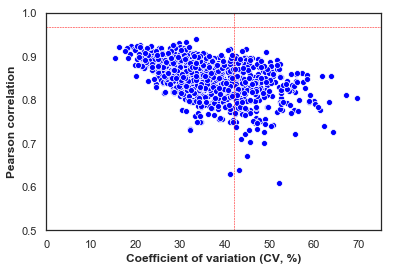

In [30]:
df_cv = df_raw[frequent_peptides].join(df_sample_map['Cell_line']).groupby('Cell_line').apply(lambda x: (x.std()/x.mean())*100)
df_cv = df_cv.to_frame('CV').reset_index().drop('level_1', axis=1)
df_cv = df_cv.groupby('Cell_line').median()
cell_lines_noHEK = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
corr_df = pd.DataFrame()
for cell_line in cell_lines_noHEK:
    corr_df.loc[cell_line,'Corr'] = df_log.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr().min().min()
corr_df = corr_df.join(df_cv)
plot = generate_qc_scatter_plot(corr_df)
plot.set_ylim(0.5,1)
plt.show()

##### First pass: consistency

In [44]:
corr_df_k4 = get_normalisation_stats('4')
# corr_df_k10 = get_normalisation_stats('10')
# corr_df_k15 = get_normalisation_stats('15')
# corr_df_k20 = get_normalisation_stats('20')
# corr_df_k30 = get_normalisation_stats('30')
# corr_df_k50 = get_normalisation_stats('50')

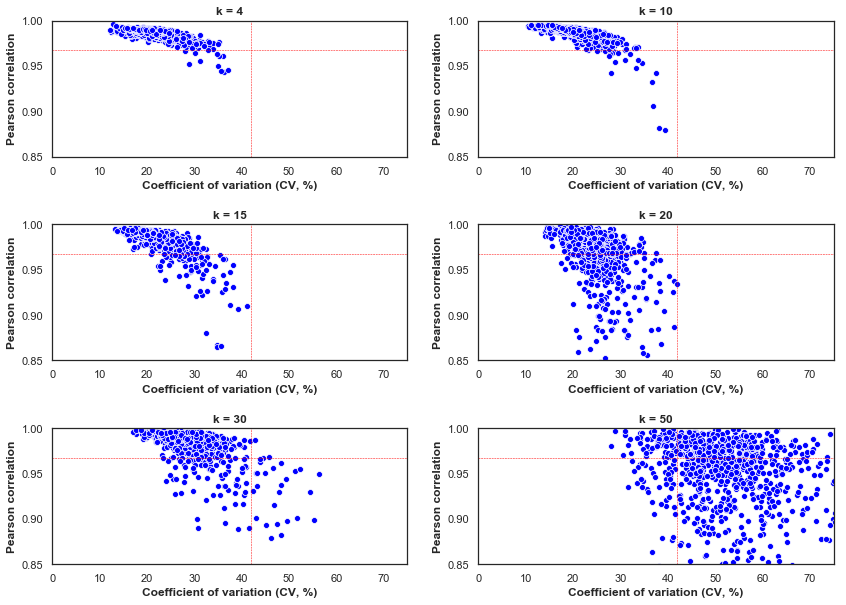

In [45]:
fig = plt.figure(figsize=[14,10])
num = 0
dtaframe_dict = {'4':corr_df_k4,'10':corr_df_k10,'15':corr_df_k15,'20':corr_df_k20,'30':corr_df_k30,'50':corr_df_k50}
for dtaframe in dtaframe_dict:
    num += 1
    ax = fig.add_subplot(3,2,num)
    plot = generate_qc_scatter_plot(dtaframe_dict[dtaframe])
    plot.set_title('k = '+dtaframe, weight='bold')
plt.subplots_adjust(hspace=0.5)
plt.show()

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k4.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k4.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k10.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k10.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k15.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k15.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k20.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k20.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k30.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k30.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k50.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k50.tsv

##### First pass: Correlation with RNA

In [46]:
df_major_compare = pd.DataFrame(columns=['RNA_corr','Rep_corr','Rep_CV'])
df_major_compare.loc['4'] = calculate_correlation_with_rna('4', corr_df_k4)
# df_major_compare.loc['10'] = calculate_correlation_with_rna('10', corr_df_k10)
# df_major_compare.loc['15'] = calculate_correlation_with_rna('15', corr_df_k15)
# df_major_compare.loc['20'] = calculate_correlation_with_rna('20', corr_df_k20)
# df_major_compare.loc['30'] = calculate_correlation_with_rna('30', corr_df_k30)
# df_major_compare.loc['50'] = calculate_correlation_with_rna('50', corr_df_k50)

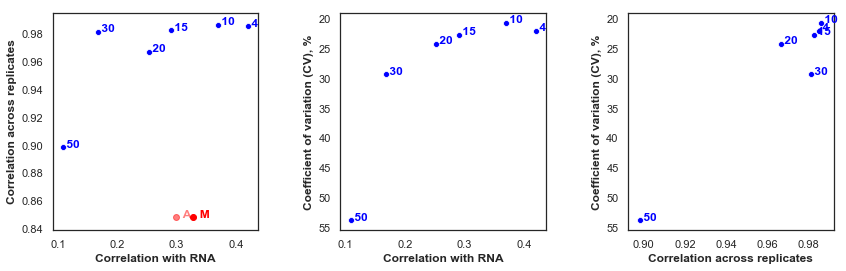

In [47]:
fig = plt.figure(figsize=[14,4])
make_comparison_plots('RNA_corr', 'Rep_corr', 1, df_major_compare, 'Show_raw')
make_comparison_plots('RNA_corr', 'Rep_CV', 2, df_major_compare, None)
make_comparison_plots('Rep_corr', 'Rep_CV', 3, df_major_compare, None)
plt.subplots_adjust(wspace=0.4)
plt.show()

##### Finer detail: consistency

In [48]:
# corr_df_k2 = get_normalisation_stats('2')
# corr_df_k3 = get_normalisation_stats('3')
# corr_df_k5 = get_normalisation_stats('5')
# corr_df_k6 = get_normalisation_stats('6')
# corr_df_k7 = get_normalisation_stats('7')
# corr_df_k8 = get_normalisation_stats('8')
# corr_df_k9 = get_normalisation_stats('9')
# corr_df_k11 = get_normalisation_stats('11')
# corr_df_k12 = get_normalisation_stats('12')

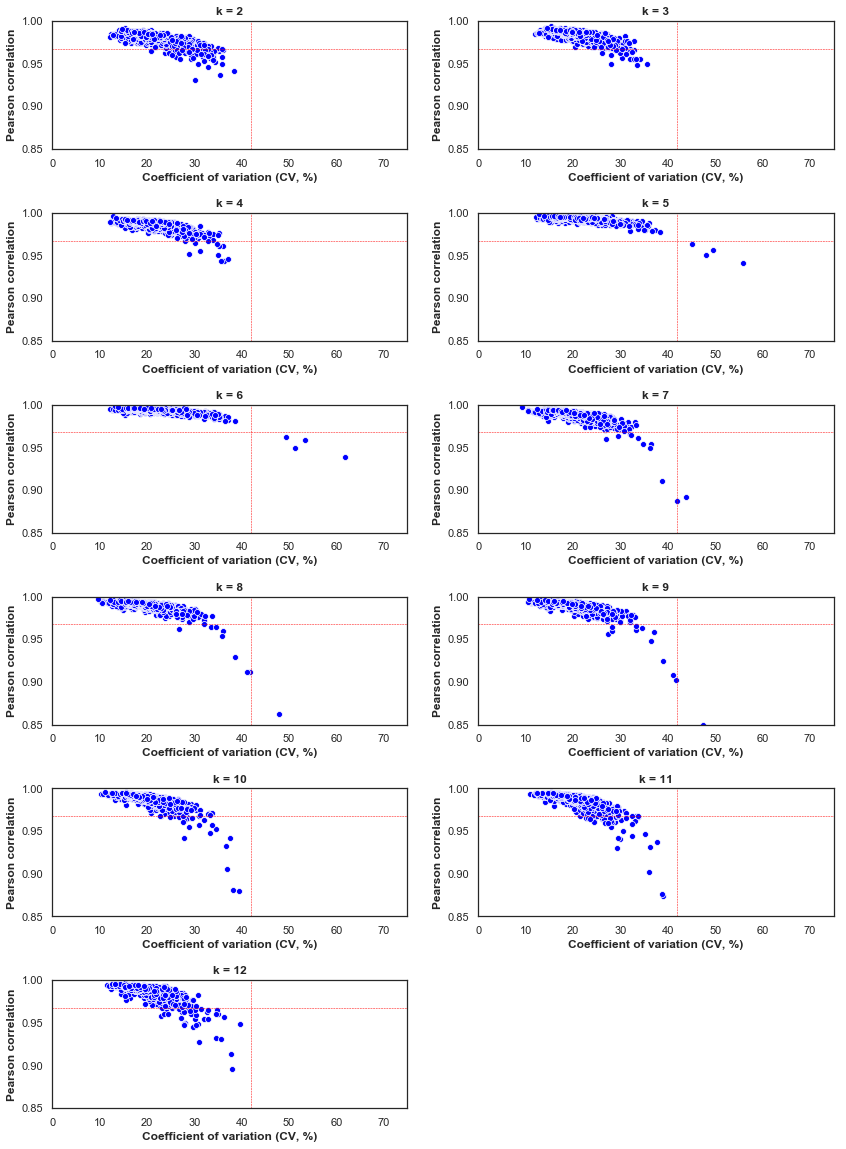

In [49]:
fig = plt.figure(figsize=[14,20])
num = 0
dtaframe_dict = {
#     '2':corr_df_k2,
#     '3':corr_df_k3,
    '4':corr_df_k4,
#     '5':corr_df_k5,
#     '6':corr_df_k6,
#     '7':corr_df_k7,
#     '8':corr_df_k8,
#     '9':corr_df_k9,
#     '10':corr_df_k10,
#     '11':corr_df_k11,
#     '12':corr_df_k12,
}
for dtaframe in dtaframe_dict:
    num += 1
    ax = fig.add_subplot(6,2,num)
    plot = generate_qc_scatter_plot(dtaframe_dict[dtaframe])
    plot.set_title('k = '+dtaframe, weight='bold')
plt.subplots_adjust(hspace=0.5)
plt.show()

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k2.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k2.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k3.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k3.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k5.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k5.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k6.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k6.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k7.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k7.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k8.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k8.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k9.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k9.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k11.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k11.tsv

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_minimal_dataset_k12.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_minimal_dataset_k12.tsv

##### Finer detail: comparison with RNA

In [50]:
df_minor_compare = pd.DataFrame(columns=['RNA_corr','Rep_corr','Rep_CV'])
# df_minor_compare.loc['2'] = calculate_correlation_with_rna('2', corr_df_k2)
# df_minor_compare.loc['3'] = calculate_correlation_with_rna('3', corr_df_k3)
df_minor_compare.loc['4'] = calculate_correlation_with_rna('4', corr_df_k4)
# df_minor_compare.loc['5'] = calculate_correlation_with_rna('5', corr_df_k5)
# df_minor_compare.loc['6'] = calculate_correlation_with_rna('6', corr_df_k6)
# df_minor_compare.loc['7'] = calculate_correlation_with_rna('7', corr_df_k7)
# df_minor_compare.loc['8'] = calculate_correlation_with_rna('8', corr_df_k8)
# df_minor_compare.loc['9'] = calculate_correlation_with_rna('9', corr_df_k9)
# df_minor_compare.loc['10'] = calculate_correlation_with_rna('10', corr_df_k10)
# df_minor_compare.loc['11'] = calculate_correlation_with_rna('11', corr_df_k11)
# df_minor_compare.loc['12'] = calculate_correlation_with_rna('12', corr_df_k12)

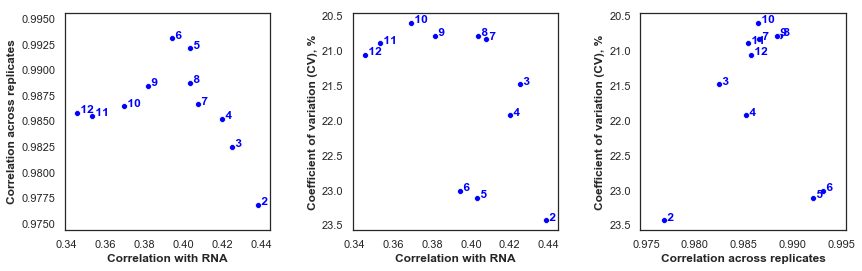

In [51]:
fig = plt.figure(figsize=[14,4])
make_comparison_plots('RNA_corr', 'Rep_corr', 1, df_minor_compare, None)
make_comparison_plots('RNA_corr', 'Rep_CV', 2, df_minor_compare, None)
make_comparison_plots('Rep_corr', 'Rep_CV', 3, df_minor_compare, None)
plt.subplots_adjust(wspace=0.4)
plt.show()

### Data QC on normalised data matrix

In [47]:
df_ruv = pd.read_csv(source_folder+'FromRUV_E0022_P06_dataset_normalised_k4.csv')

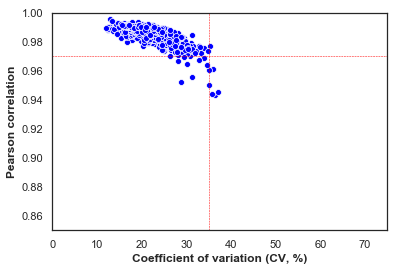

Number of cell_lines with poor qc results: 15


In [48]:
cv_thresh = 35
corr_thresh = 0.97
plot = sns.scatterplot(x='CV', y='Corr', data=corr_df_k4, color='blue')
plot.set_xlabel('Coefficient of variation (CV, %)', weight='bold')
plot.set_ylabel('Pearson correlation', weight='bold')
plot.axvline(x=cv_thresh, color='red', linestyle='--', linewidth=0.5)
plot.axhline(y=corr_thresh, color='red', linestyle='--', linewidth=0.5)    
plot.set_xlim(0,75)
plot.set_ylim(0.85, 1)
plt.show()
poor_qc_lines = corr_df_k4[lambda x: (x.Corr < corr_thresh) | (x.CV > cv_thresh)].index.tolist()
print('Number of cell_lines with poor qc results:',len(poor_qc_lines))

##### Identify poor quality samples

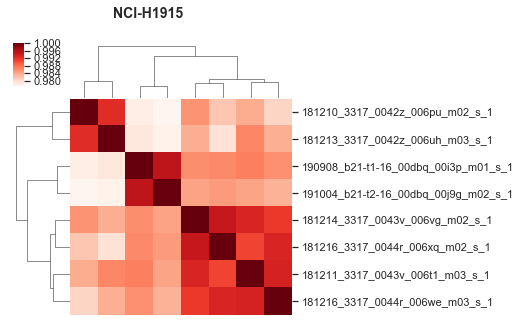

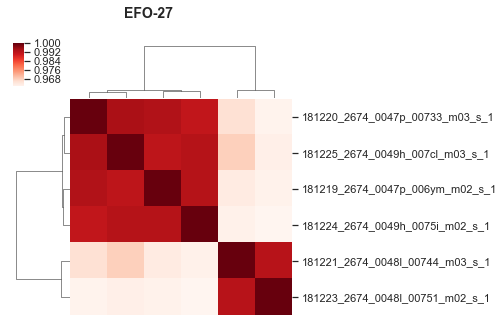

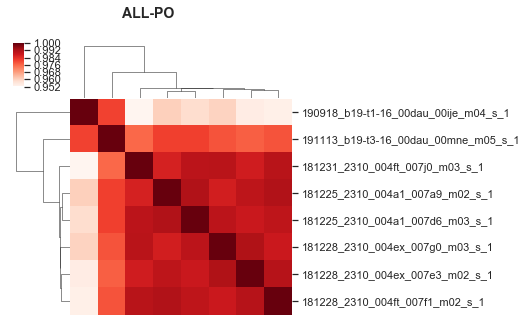

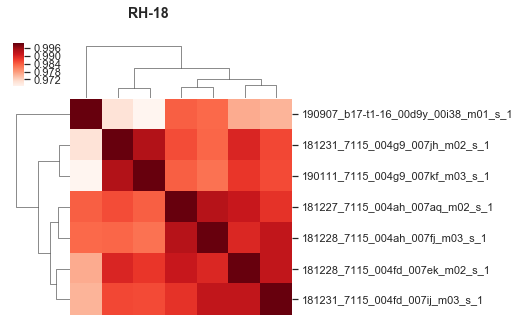

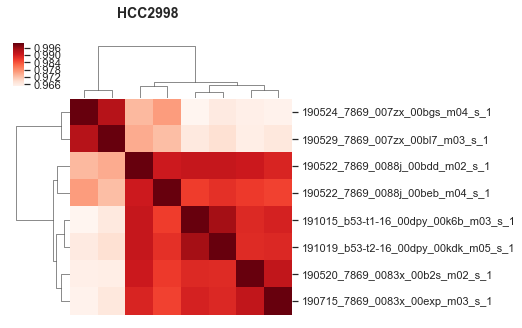

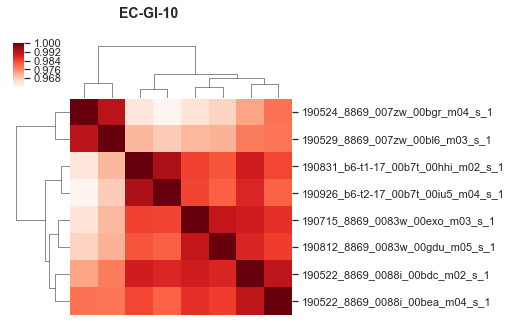

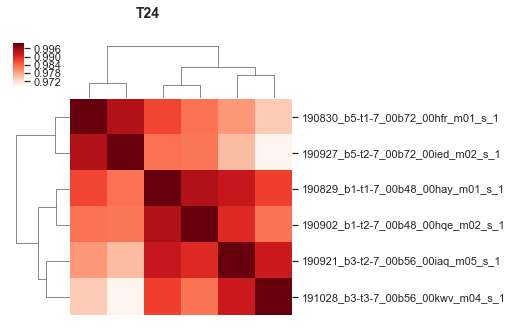

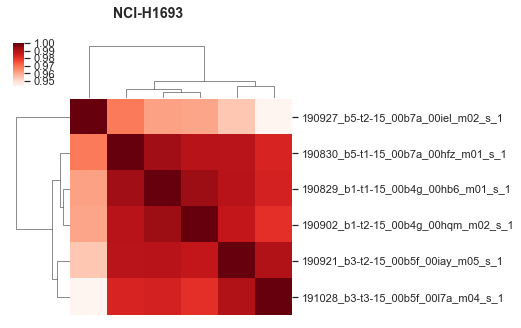

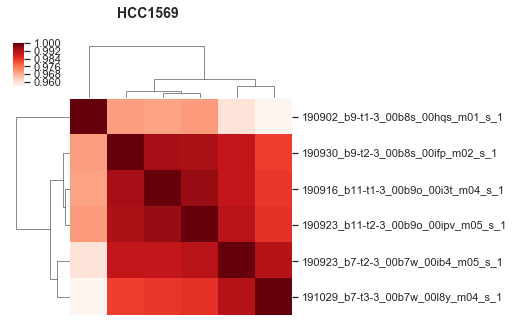

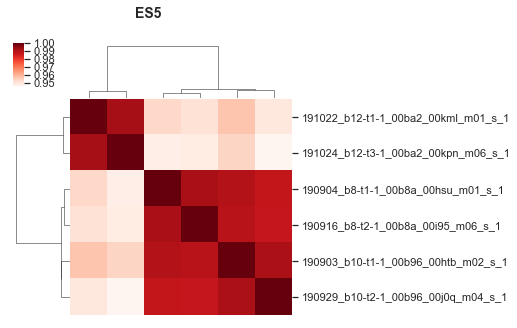

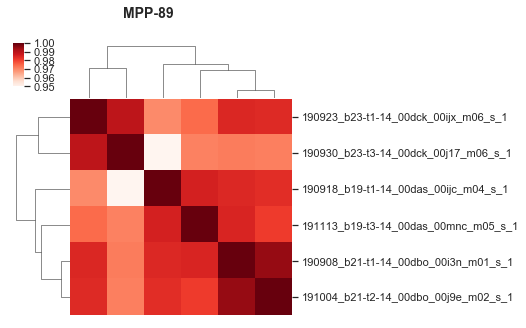

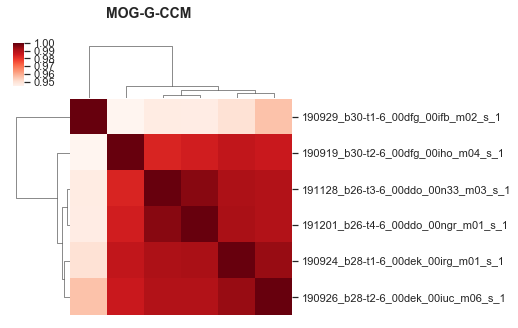

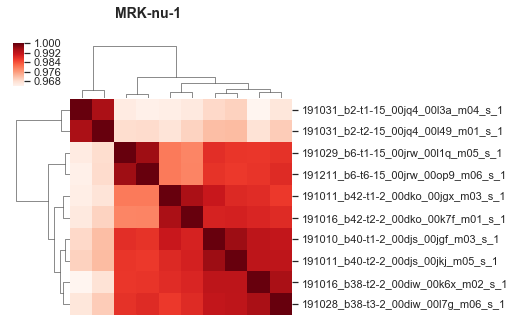

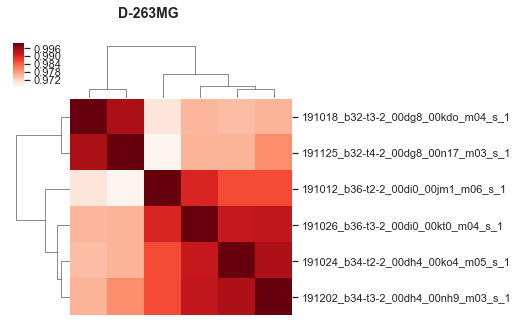

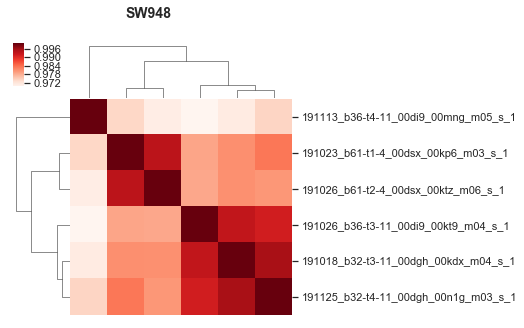

In [49]:
for cell_line in poor_qc_lines:
    curr_df = df_ruv.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr()
    plot = sns.clustermap(curr_df, cmap='Reds', yticklabels=True, xticklabels=False, figsize=[5,5])
    plot.fig.suptitle(cell_line, weight='bold', fontsize=14)
    plt.show()

In [50]:
lims_id_1 = ['0042z',
             '0048l',
             '007zx',
             '007zw',
             '00b72',
             '00ba2',
             '00jq4',
             '00dg8']
lims_id_2 = ['00ije',
             '00i38',
             '00iel',
             '00hqs',
             '00j17',
             '00ifb',
             '00mng']
lims_to_remove = lims_id_1 + lims_id_2
files_to_remove = []
for file in df_sample_map.index.tolist():
    for lims in lims_to_remove:
        if lims in file:
            files_to_remove.append(file)
print('Found # files to remove:',len(files_to_remove))
print('Should have found # of files to remove:',len(lims_id_1)*2+len(lims_id_2))

Found # files to remove: 23
Should have found # of files to remove: 23


##### Asssess removal of poor quality samples

In [51]:
corr_df_k4_mod = corr_df_k4.copy()
for cell_line in poor_qc_lines:
    curr_df = df_ruv.join(df_sample_map['Cell_line'])[lambda x: x.Cell_line == cell_line].drop('Cell_line', axis=1)
    curr_df = curr_df.drop([x for x in curr_df.index.tolist() if x in files_to_remove])
    corr_df_k4_mod.loc[cell_line,'Corr'] = curr_df.transpose().corr().min().min()
    corr_df_k4_mod.loc[cell_line,'CV'] = curr_df.apply(lambda x: 2**x).apply(lambda x: x.std()/x.mean()*100).median()

Number of cell_lines with poor qc results: 0


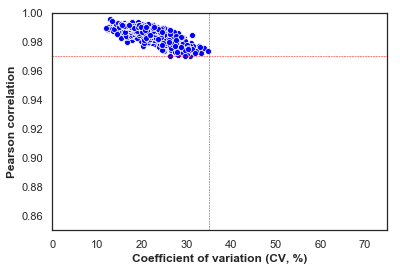

In [52]:
cv_thresh = 35
corr_thresh = 0.97
plot = sns.scatterplot(x='CV', y='Corr', data=corr_df_k4_mod, color='blue')
plot.set_xlabel('Coefficient of variation (CV, %)', weight='bold')
plot.set_ylabel('Pearson correlation', weight='bold')
plot.axvline(x=cv_thresh, color='red', linestyle='--', linewidth=0.5)
plot.axhline(y=corr_thresh, color='red', linestyle='--', linewidth=0.5)    
plot.set_xlim(0,75)
plot.set_ylim(0.85, 1)
new_poor_qc_lines = corr_df_k4_mod[lambda x: (x.Corr < corr_thresh) | (x.CV > cv_thresh)].index.tolist()
print('Number of cell_lines with poor qc results:',len(new_poor_qc_lines))
plt.show()

##### Remove poor quality samples

In [85]:
df_ruv_qc = df_ruv.drop(files_to_remove)
# df_ruv_qc.to_csv(source_folder+'FromRUV_E0022_P06_dataset_normalised_k4_postqc.csv.gz', compression='gzip')
print('Number of files before qc: ',len(df_ruv))
print('Number of files after qc: ',len(df_ruv_qc))

Number of files before qc:  7139
Number of files after qc:  7116


In [86]:
df_sample_map_qc = df_sample_map[lambda x: x.index.isin(df_ruv_qc.index.tolist())]
# df_sample_map_qc.to_csv('E0022_P06_final_sample_map.txt', sep='\t')
dict_sample_map = df_sample_map_qc.to_dict()
print('Number of files in sample map: ',len(df_sample_map_qc))

Number of files in sample map:  7116


In [55]:
df_ruv_qc = pd.read_csv(source_folder+'FromRUV_E0022_P06_dataset_normalised_k4_postqc.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_sample_map_qc = pd.read_csv('E0022_P06_final_sample_map.txt', sep='\t').set_index('Automatic_MS_filename')
dict_sample_map = df_sample_map_qc.to_dict()

### Examine negative control peptides after normalisation

##### Negative control peptides

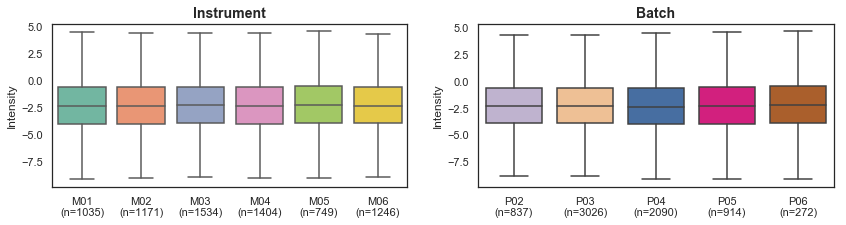

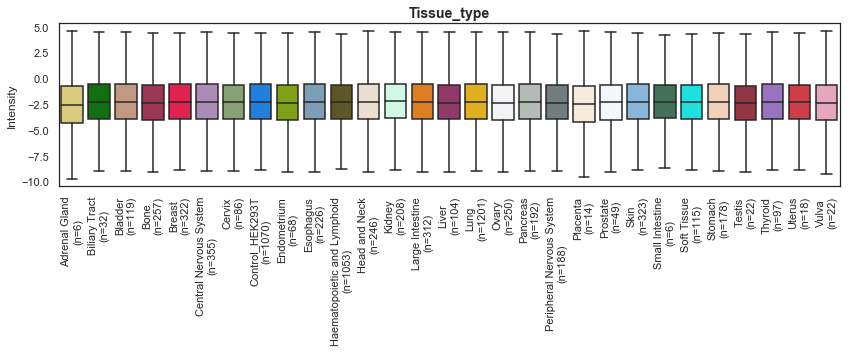

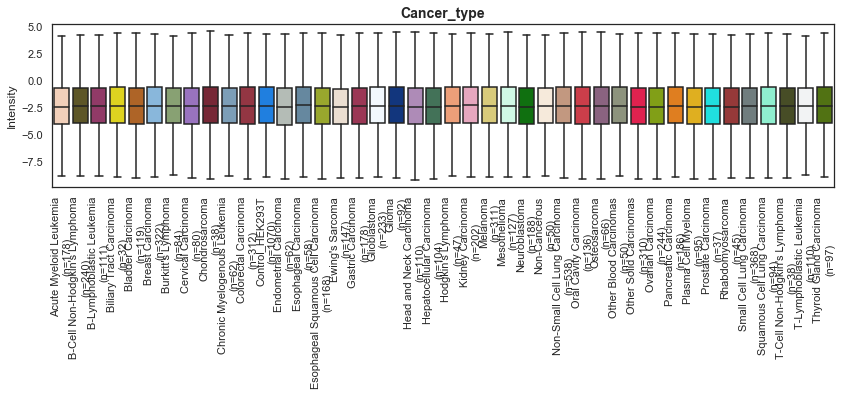

In [56]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_ruv_qc, control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_ruv_qc, control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

##### Almost control peptides

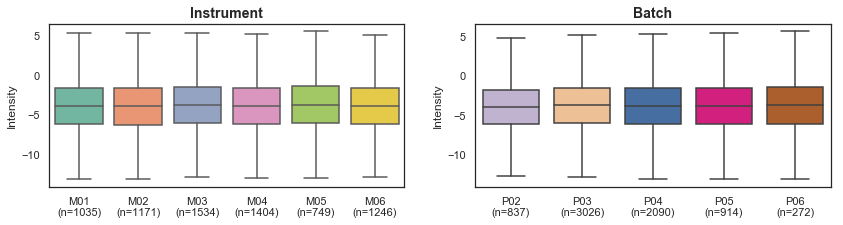

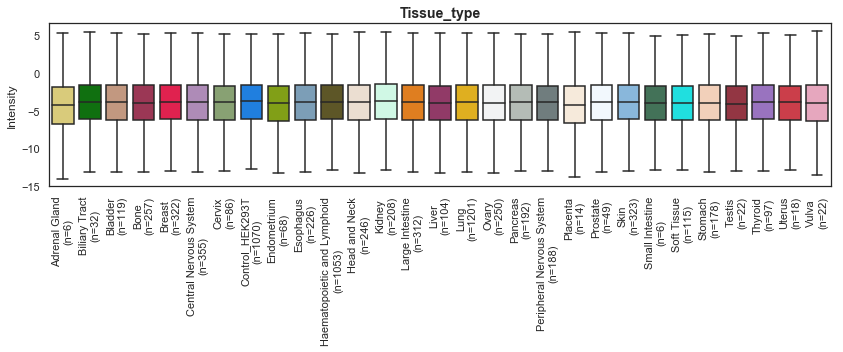

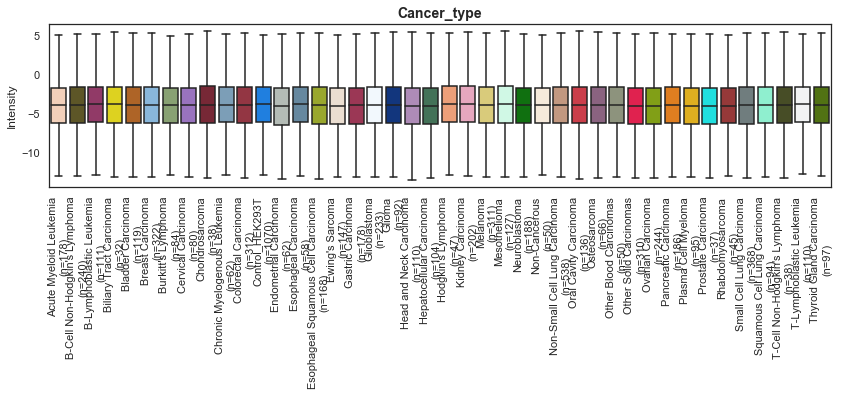

In [57]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_ruv_qc, almost_control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_ruv_qc, almost_control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, almost_control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, almost_control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

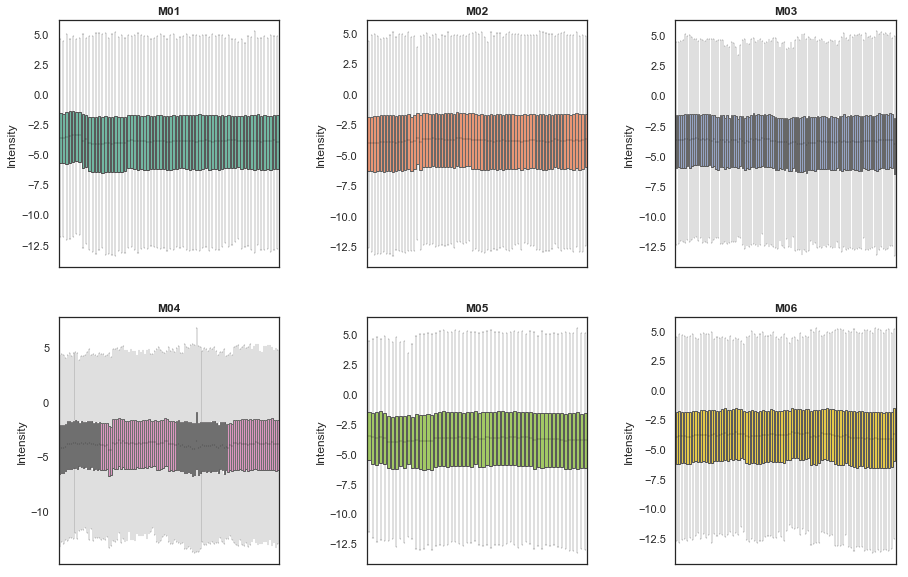

In [89]:
make_hek_cleaning_plot(df_ruv)

##### iRT peptides

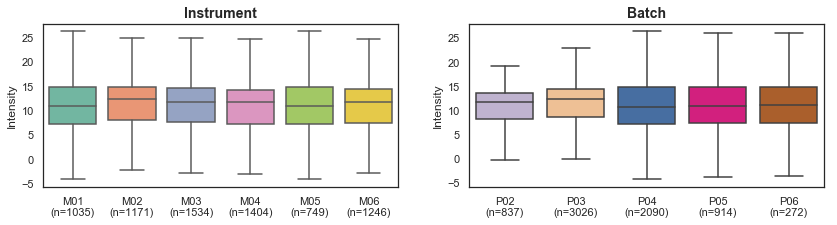

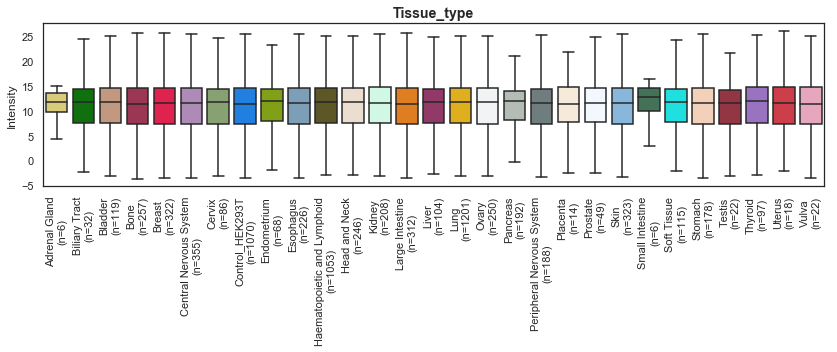

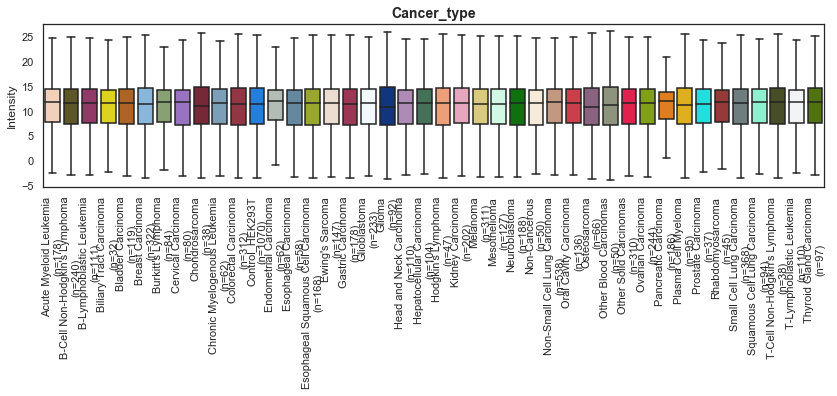

In [59]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_ruv_qc, irt_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_ruv_qc, irt_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, irt_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_ruv_qc, irt_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

### Examine correlation with RNA after normalisation

##### Peptide-level correlation

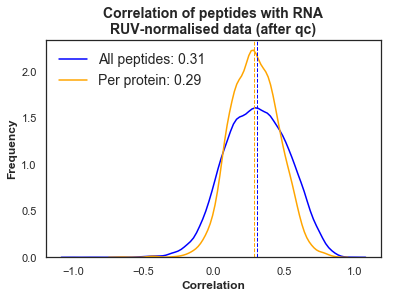

In [62]:
get_peptide_correlation_with_rna(df_ruv_qc,'RUV-normalised data (after qc)')

##### Correlation after Diffacto roll-up

In [90]:
protein_df = df_ruv_qc.transpose().reset_index()
protein_df[['Protein','Peptide','ModPeptide']] = protein_df['index'].str.split('=',expand=True)
protein_df = protein_df.drop(['index','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
# protein_df.to_csv(source_folder+'ForDiffacto_E0022_P06_ruv_k4_qc.txt',index=False)

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_ruv_k4_qc.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_ruv_k4_qc.tsv

In [64]:
df_protein_ruv = pd.read_csv(source_folder+'FromDiffacto_E0022_P06_ruv_k4_qc.tsv', sep='\t')
df_protein_ruv = df_protein_ruv.drop(['N.Pept','Q.Pept','S/N','P(PECA)'], axis=1).set_index('Protein').transpose()
df_protein_ruv = df_protein_ruv.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()

In [65]:
rna_corr_ruv = get_rna_protein_correlation(df_protein_ruv)

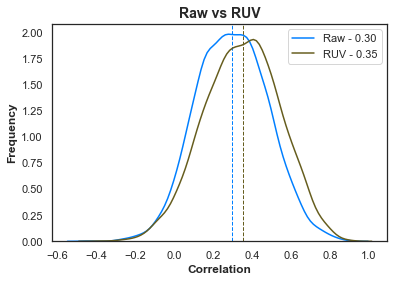

In [97]:
generate_correlation_plot([rna_corr_raw, rna_corr_ruv], ['Raw','RUV'], 'Raw vs RUV')

### Perform technical replacement 

In [156]:
# def get_hek_techrep(hek_type, rep_num, sample_map):
#     num = 0
#     curr_list = sample_map[lambda x: x.Cell_line == hek_type].index.tolist()
#     random.shuffle(curr_list)
#     for sample in curr_list:
#         sample_map.loc[sample,'TechRep'] = str(rep_num)
#         num += 1
#         if num == 6:
#             rep_num += 1
#             num = 0
#     rep_num += 1        
#     return sample_map, rep_num

# df_sample_map_techrep = df_sample_map_qc[['Cell_line','SIDM']].rename(columns={'SIDM':'TechRep'})
# df_sample_map_techrep, rep_num = get_hek_techrep('Control_HEK293T_std_H002', 0, df_sample_map_techrep)
# df_sample_map_techrep, rep_num = get_hek_techrep('Control_HEK293T_std_H003', rep_num, df_sample_map_techrep)
# df_sample_map_techrep, rep_num = get_hek_techrep('Control_HEK293T_lys', rep_num, df_sample_map_techrep)
# df_sample_map_techrep.to_csv(source_folder+'E0022_P06_techRep_mapping.txt')

In [157]:
# peptide_list = df_ruv_qc.columns.tolist()
# df_imp = df_ruv_qc.join(df_sample_map_techrep['TechRep'])
# for curr_peptide in peptide_list:
#     df_imp.loc[:,curr_peptide] = df_imp.groupby('TechRep')[curr_peptide].apply(lambda x: x.fillna(x.mean() if x.notna().sum() >= 2 else x.fillna(np.nan)))
# df_imp = df_imp.drop('TechRep', axis=1)
# df_imp.to_csv(source_folder+'E0022_P06_ruv_k4_qc_techRep.csv.gz', sep='\t', compression='gzip')
# protein_df = df_imp.transpose().reset_index()
# protein_df[['Protein','Peptide','ModPeptide']] = protein_df['index'].str.split('=',expand=True)
# protein_df = protein_df.drop(['index','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
# protein_df.to_csv(source_folder+'ForDiffacto_E0022_P06_ruv_k4_qc_techRep.txt',index=False)

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_ruv_k4_qc_techRep.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_ruv_k4_qc_techRep.tsv

In [16]:
print('Missing values before technical replacement:',format(df_ruv_qc.isna().sum().sum()/df_ruv_qc.size*100,'.2f'),'%')
print('Missing values after technical replacement:',format(df_imp.isna().sum().sum()/df_imp.size*100,'.2f'),'%')

Missing values before technical replacement: 57.01 %
Missing values after technical replacement: 42.83 %


### Compare with median normalisation

##### Perform median normalisation

In [67]:
curr_df = df_raw.transpose()
overall_median = np.log2(curr_df.median().mean())
med_norm_vals = curr_df.apply(np.log2).median()-overall_median
df_median = curr_df.apply(np.log2).subtract(med_norm_vals).transpose()

In [91]:
def make_median_plot(dtaframe, title):
    plot_df = dtaframe.join(df_sample_map[['Instrument','Date']]).sort_values(['Instrument','Date']).drop(['Instrument','Date'], axis=1).transpose()
    plot = plot_df.plot(kind='box', figsize=[14,3], patch_artist=True, showfliers=False, medianprops=dict(linewidth=2), color={'boxes':'white','medians':'red'})
    plot.set_xticklabels([])
    plot.set_ylabel('Median', weight='bold')
    plot.set_xlabel('Sample', weight='bold')
    plot.set_title(title, weight='bold')
    plot.grid(False)
    plt.show()

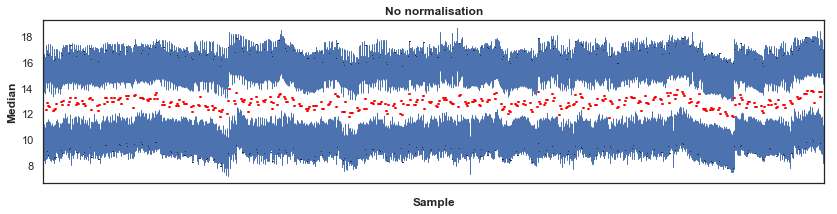

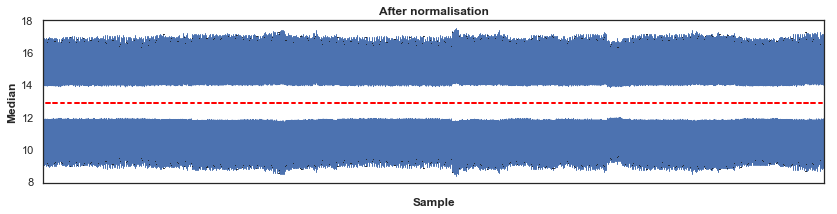

In [92]:
make_median_plot(df_log, 'No normalisation')
make_median_plot(df_median, 'After normalisation')

##### Consistency of replicates

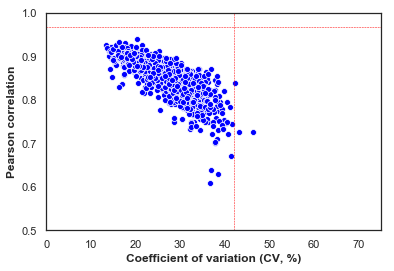

In [70]:
df_cv = df_median[frequent_peptides].apply(lambda x: 2**x).join(df_sample_map['Cell_line']).groupby('Cell_line').apply(lambda x: (x.std()/x.mean())*100)
df_cv = df_cv.to_frame('CV').reset_index().drop('level_1', axis=1)
df_cv = df_cv.groupby('Cell_line').median()
cell_lines_noHEK = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
corr_df_median = pd.DataFrame()
for cell_line in cell_lines_noHEK:
    corr_df_median.loc[cell_line,'Corr'] = df_median.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr().min().min()
corr_df_median = corr_df_median.join(df_cv)
plot = generate_qc_scatter_plot(corr_df_median)
plot.set_ylim(0.5,1)
plt.show()

##### Correlation with transcriptome (peptide-level)

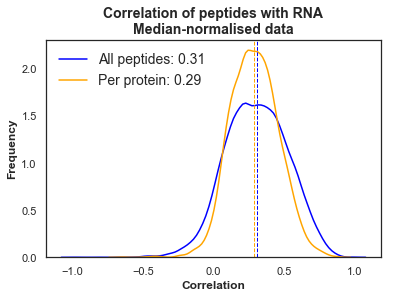

In [71]:
get_peptide_correlation_with_rna(df_median,'Median-normalised data')

##### Correlation with transcriptome (Diffacto)

In [72]:
protein_df = df_median.transpose().reset_index()
protein_df[['Protein','Peptide','ModPeptide']] = protein_df['Identifier'].str.split('=',expand=True)
protein_df = protein_df.drop(['Identifier','ModPeptide'],axis=1).set_index('Protein').reset_index().set_index('Peptide').reset_index().rename(columns={'Peptide':'','Protein':''})
protein_df.to_csv(source_folder+'ForDiffacto_E0022_P06_log_median_normalised.txt',index=False)

Modify the file paths in the following command as appropriate:

python3 diffacto/run_diffacto.py -i source_folder+ForDiffacto_E0022_P06_log_median_normalised.txt -log2 True -impute_threshold 1.1 -out source_folder+FromDiffacto_E0022_P06_log_median_normalised.tsv

In [158]:
df_protein_median = pd.read_csv(source_folder+'FromDiffacto_E0022_P06_log_median_normalised.tsv', sep='\t')
df_protein_median = df_protein_median.drop(['N.Pept','Q.Pept','S/N','P(PECA)'], axis=1).set_index('Protein').transpose()
df_protein_median = df_protein_median.join(df_sample_map['Cell_line']).groupby('Cell_line').mean()

In [159]:
rna_corr_median = get_rna_protein_correlation(df_protein_median)

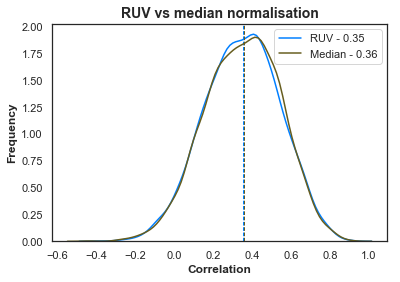

In [160]:
generate_correlation_plot([rna_corr_ruv, rna_corr_median], ['RUV','Median'], 'RUV vs median normalisation')

##### Negative control peptides

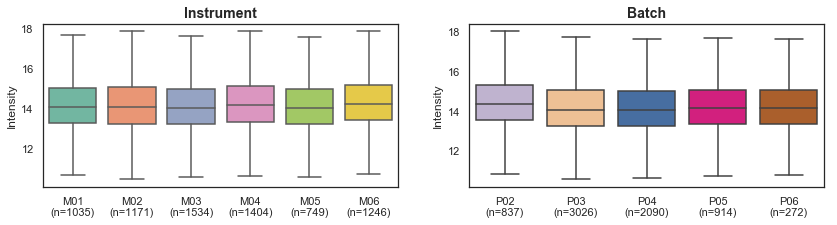

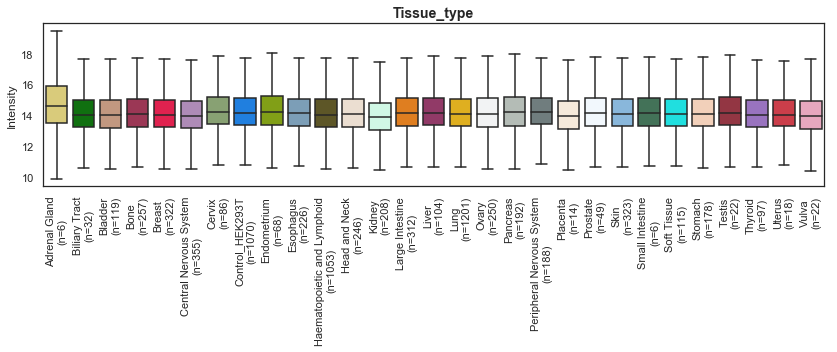

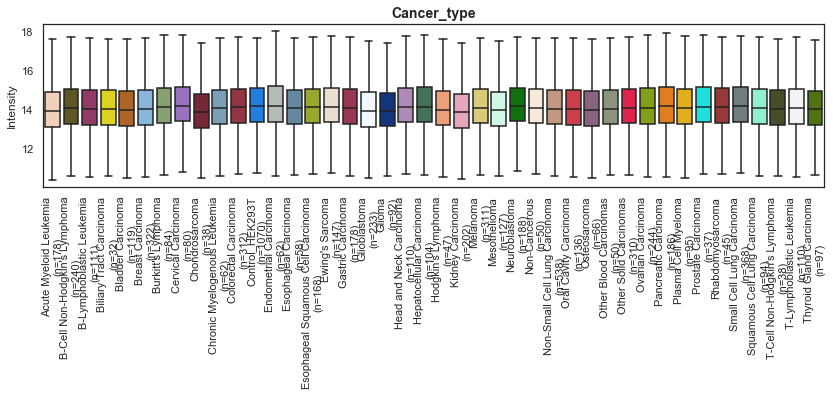

In [161]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_median, control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_median, control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

##### Almost control peptides

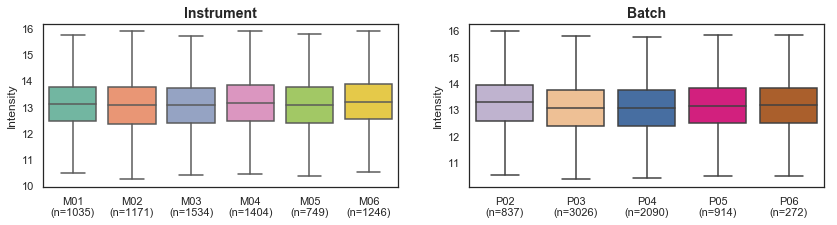

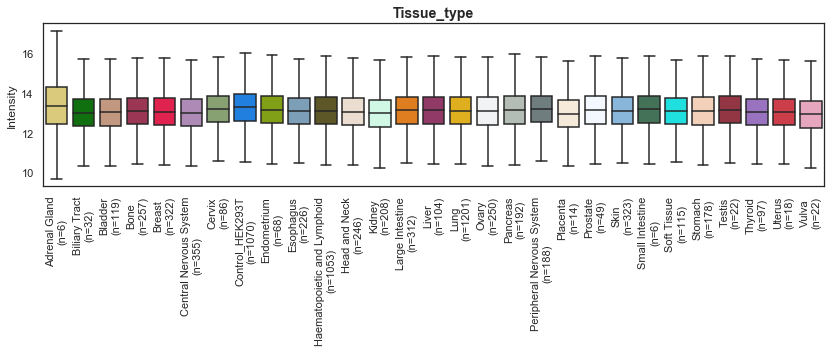

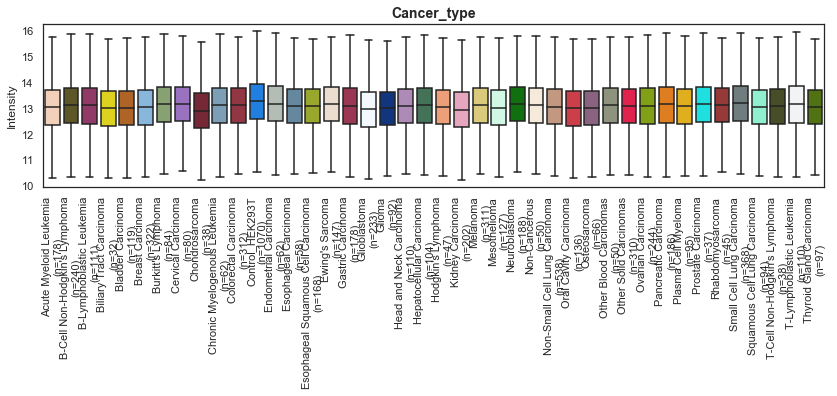

In [162]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_median, almost_control_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_median, almost_control_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, almost_control_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, almost_control_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()

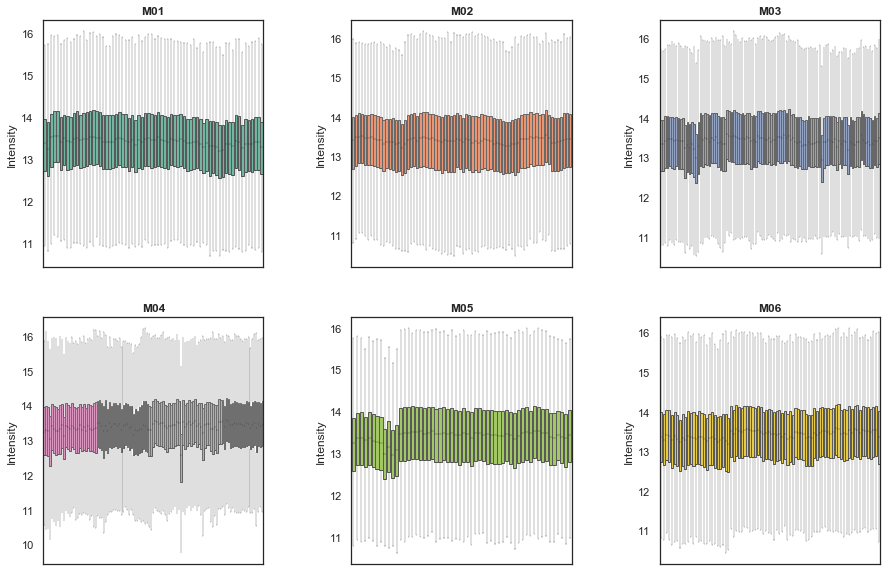

In [163]:
make_hek_cleaning_plot(df_median)

#### iRT peptides

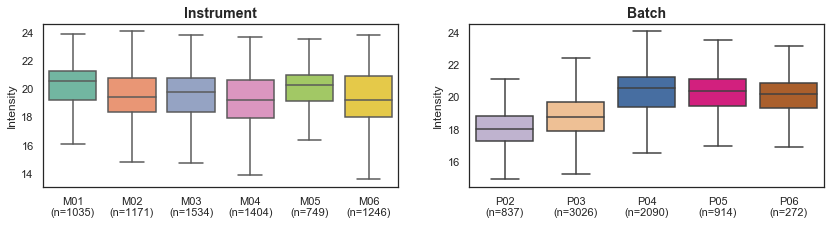

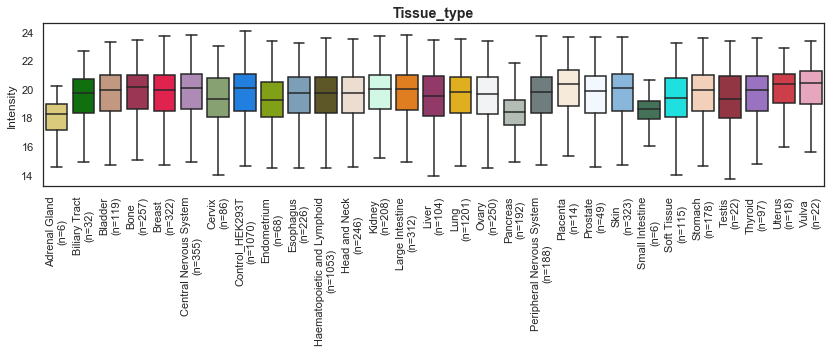

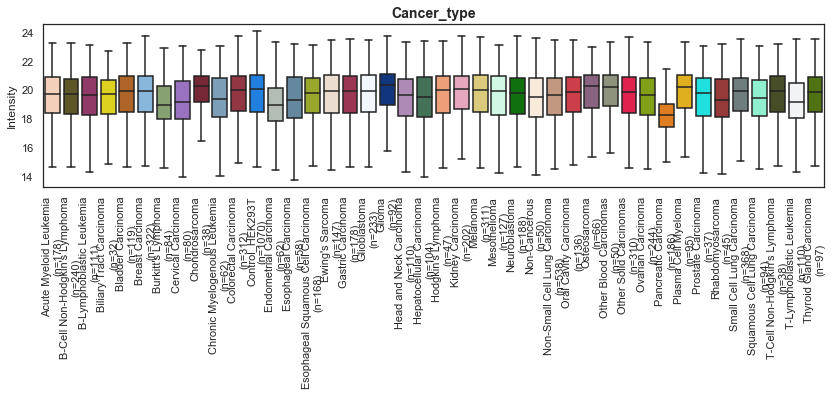

In [164]:
fig = plt.figure(figsize=[14,3])
ax = fig.add_subplot(1,2,1)
plot = generate_neg_control_plot(df_median, irt_peptides, 'Instrument', instrument_colours, 0)
ax = fig.add_subplot(1,2,2)
plot = generate_neg_control_plot(df_median, irt_peptides, 'Batch', batch_colours, 0)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, irt_peptides, 'Tissue_type', tissue_colours, 90)
plt.show()
fig = plt.figure(figsize=[14,3])
plot = generate_neg_control_plot(df_median, irt_peptides, 'Cancer_type', cancer_colours, 90)
plt.show()